<h1> <b> OBJETIVO DEL PROYECTO </b></h1>

<h2> <b> CREAR UN GENERADOR DE DIÁLOGO, UN CLASIFICADOR DE "QUOTES" Y VISUALIZACIONES VARIAS, PARA PUBLICARLO EN UNA WEB PARA LOS FANS DE FRIENDS EN HONOR A LA REUNIÓN DE ESTE AÑO </b></h2>


<h1> <b> DATASETS </b></h1>

<ul>
  <li><h2> <b>"friends_quotes"</b> : dataset de Kaggle https://www.kaggle.com/ryanstonebraker/friends-transcript </li></h2>
  <li><h2> <b>"Guest_Stars_DF"</b> : dataset creado a partir del friends_quotes dataset y modificado manualmente. Este contiene las líneas que han tenido diferentes actores/actrices invitados/as a la serie durante las 10 temporadas. </li></h2>
  <li><h2> <b>"season1_df_modified"</b> : dataset creado a partir del friends_quotes dataset y modificado manualmente. Este contiene las conversaciones por parejas (no contiene las conversaciones grupales), de los 9 personajes que más frases tienen en la primera temporada </li></h2>
  <li><h2> <b>"script_ross"</b> : dataset creado a partir del friends_quotes dataset y modificado manualmente. Este contiene los diálogos entre Ross y otras personas de la serie en la primera temporada.  </li></h2>
</ul>

<h1> <b> PREGUNTAS </b></h1>

<ol>
  <h2> <b> <li>¿Cuáles son los 9 personajes con más líneas de texto en cada temporada?</li> </b> </h2>
<h2> <b> <li> ¿Cuáles de estos personajes hablan más entre ellos en la primera temporada? </li> </b> </h2>
<h2> <b> <li>¿Qué actores/actrices invitados aparecieron durante las 10 temporadas?</li> </b> </h2>
<h2> <b> <li>¿Quién de los 6 personajes principales es más positivo/negativo? </li> </b> </h2>
<h2> <b> <li>Clasificador de "quotes": ¿Quién ha dicho qué? </li> </b> </h2>
<h2> <b> <li>Generador de diálogo: ¿qué diría Ross?</li> </b> </h2>
</ol>

#####Code

In [ ]:
# Data Wrangling Libraries

import pandas as pd
import numpy as np
import re

# NLP

import nltk
from textblob import TextBlob
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report


# Data Visualisation Libraries

import seaborn as sns
import networkx as nx
import cufflinks as cf
import plotly.express as px
from ipywidgets import interact
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
from ipywidgets import Dropdown, IntSlider
import ipywidgets as widgets
import plotly.graph_objects as go

#Others
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
friends = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/friends_quotes.csv")
season_1_main_characters = pd.read_excel("/content/gdrive/MyDrive/Colab Notebooks/season1_df_modified.xlsx")
guest_stars = pd.read_excel("/content/gdrive/MyDrive/Colab Notebooks/Guest_Stars_DF.xlsx")


In [ ]:
#el episodio 16 no está bien "escrapeado", así que eliminamos las líneas.
friends.drop(friends[(friends["season"] == 1) & (friends["episode_number"] == 16)].index,inplace = True)
# eliminamos las líneas en la columna "author" es "All"
friends.drop(friends[(friends["author"] == "All")].index,inplace = True)

In [ ]:
friends["author"] = friends["author"].str.replace("ms. geller","mrs. geller").str.replace("judy","mrs. geller").str.replace("frank jr","frank")

In [ ]:
friends["author"] = friends["author"].str.replace("\(([^)]+)\)","").str.lower().str.strip()

In [ ]:
chandler =["chan","chandle","chandlers"]
monica =["young monica","fat monica","mnca","monic","monica about to have a heart attack","monica to amy","monica to emma","monica to ross"] 
joey = ["fat joey","joe"]
phoebe = ["phoe","phoeb","phoebe looks down"]
rachel = ["big nosed rachel","rach","rahcel","rache","rachel opens their door","rachel to emma","racel"]
ross = ["ross first has a look of 'huh' then changes it to sarcastic happy","ross looks down","ross makes some sort of sound to let us know it hurt","ross starts playing with a plate","ross starts talking over her 'do you remember' line","ross to monica","ross with a look of wondering how long this is going to go on on his face","young ross","ros"]

In [ ]:
def replace_author(i):
    if i in chandler: 
        i = "chandler" 
    elif i in monica:
        i = "monica"
    elif i in joey: 
        i = "joey"
    elif i in phoebe:
        i = "phoebe"
    elif i in rachel: 
        i = "rachel"
    elif i in ross:
        i = "ross"
    else:
        return i

In [ ]:
friends["author"] = friends["author"].apply(replace_author).str.capitalize()

#**¿Cuáles son los 9 personajes con más líneas de texto en cada temporada?**

![alt text](https://media.giphy.com/media/JQSCdkVWIY1CF51sjG/giphy.gif)

Image from [Giphy](https://giphy.com/)

In [ ]:
#@title
@interact(Season = IntSlider(min=1, max=10, step=1,value=1))
def more_common_characters(Season):
    more_common = friends[friends.season == Season]["author"].value_counts().head(9).index.to_list()
    sns.set(rc={'figure.figsize':(7,7),'axes.facecolor':'black'}, font_scale=1.5)
    palette = ["red","yellow","#23c6f7"]
    sns.countplot(y='author', data=friends[(friends.author.isin(more_common)) & (friends.season == Season)], order = more_common, palette = palette)
    plt.xlabel("Number of lines")
    plt.ylabel("Character")
    plt.title('9 Characters with more lines per season')
    plt.show()

interactive(children=(IntSlider(value=1, description='Season', max=10, min=1), Output()), _dom_classes=('widge…

#####Code

In [ ]:
conversation_weights = pd.DataFrame(season_1_main_characters["Conversation"].value_counts(normalize = True)).reset_index()
conversation_weights

,index,Conversation
0,"Ross, Rachel",0.171171
1,"Ross, Carol",0.114114
2,"Chandler, Joey",0.113113
3,"Rachel, Monica",0.086086
4,"Chandler, Phoebe",0.083083
5,"Ross, Joey",0.079079
6,"Susan, Ross",0.065065
7,"Monica, Joey",0.062062
8,"Chandler, Janice",0.054054
9,"Phoebe, Rachel",0.038038


In [ ]:
conversation_weights[["A","B"]] = conversation_weights["index"].str.split(",",expand=True)

In [ ]:
conversation_weights["A"] = conversation_weights["A"].str.strip()
conversation_weights["B"] = conversation_weights["B"].str.strip()

#**¿Cuáles de estos personajes hablan más entre ellos en la primera temporada?**


![alt text](https://media.giphy.com/media/S9ndPlQlnSnqvGMMZv/giphy.gif)

Image from [Giphy](https://giphy.com/)


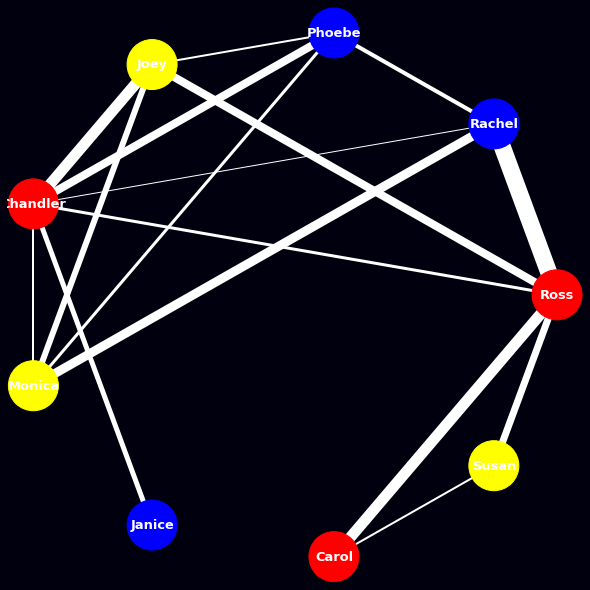

In [ ]:
#@title
plt.rcParams["figure.figsize"] = (8,8)

G = nx.Graph()
G.add_node("Ross", color='red')
G.add_node("Rachel", color='blue')
G.add_node("Phoebe", color='blue')
G.add_node("Joey", color='yellow')
G.add_node("Chandler", color='red')
G.add_node("Monica", color='yellow')
G.add_node("Janice", color='blue')
G.add_node("Carol", color='red')
G.add_node("Susan", color='yellow')

for i in range(len(conversation_weights)):
    G.add_edge(conversation_weights["A"][i],conversation_weights["B"][i], weight=round(conversation_weights["Conversation"][i]*100))

colors_nodes = nx.get_node_attributes(G,'color').values()
weights = nx.get_edge_attributes(G,'weight').values()
pos = nx.circular_layout(G)

fig = plt.figure()
nx.draw(G, pos, 
        edge_color="white", 
        width=list(weights),
        with_labels=True,
        node_color= colors_nodes, node_size=2500, font_weight='bold', font_color='white', font_size = 13)

fig.set_facecolor("#00000F")

####Code

In [ ]:
guest_stars = pd.pivot_table(guest_stars,index=["Actor","season"],
                values = ["quote"],           
               aggfunc='count',fill_value=0)

In [ ]:
guest_stars.reset_index(inplace = True)

#**¿Qué actores/actrices invitados aparecieron durante las 10 temporadas?**


 ![alt text]( https://media.giphy.com/media/KzPyQ5n4rOYmSh4gRg/giphy.gif)

Image from [Giphy](https://giphy.com/)

In [ ]:
#@title
fig = px.bar(guest_stars, x="season", y="quote", color = "Actor", labels = {"quote": "Number of lines", "season": "Season"})
fig.show()

####Code

In [ ]:
main_characters = ["Ross", "Joey","Chandler","Phoebe","Rachel","Monica"]

In [ ]:
friends2= friends[friends.author.isin(main_characters)].drop(columns=['episode_number', 'episode_title', "quote_order"]).reset_index(drop = True)

In [ ]:
friends2["quote"] = friends2["quote"].str.replace("\(([^)]+)\)","").str.strip().str.lower().str.split("[.|!|?]", expand = False)

In [ ]:
friends2 = friends2.explode("quote")

In [ ]:
friends2.reset_index(drop = True, inplace = True)

In [ ]:
scene = friends2[friends2["quote"].str.contains("scene:")].index.to_list()

In [ ]:
friends2 = friends2.drop(friends2.index[scene])

In [ ]:
friends2["quote"] = friends2["quote"].str.replace("[^a-zA-Z' ]","")

In [ ]:
friends2.reset_index(drop = True, inplace = True)

In [ ]:
indexes = [] #eliminamos celdas vacías
for i in range(len(friends2["quote"])):
    if len(friends2["quote"][i]) == 0:
        indexes.append(i)

In [ ]:
friends2 = friends2.drop(friends2.index[indexes]).reset_index(drop = True)

In [ ]:
friends2["quote"] = friends2["quote"].str.strip().str.replace("'\s","").str.replace("'cause","because").str.replace("you know","y'know").str.replace("you are","you're").str.replace("come on","c'mon").str.replace("'kay","okay").str.replace("'em","them").str.replace("doin'","doing").str.replace("(ya)","you").str.replace("lemme","let me").str.replace("gonna", "going to").str.replace("'", "")

In [ ]:
def polarity(x):
    return TextBlob(x).polarity

In [ ]:
def sentiment_analysis(x):
    if x > 0.5: 
        x = "Positive"
    elif x < -0.5:
        x = "Negative"
    else:
        x = "Neutral"
    return x
#Less than 0 denotes Negative, I prefer to set < - 0.5
#Equal to 0  denotes Neutral
#Greater than 0 denotes Positive, I prefer to set > 0.5

In [ ]:
#min_df ignore terms that have a document frequency strictly lower than the given threshold.
vectorizer = CountVectorizer(min_df = 0.0002, ngram_range =(1,1))
matrix = vectorizer.fit_transform(friends2["quote"])
matrix

<88531x1625 sparse matrix of type '<class 'numpy.int64'>'
	with 424199 stored elements in Compressed Sparse Row format>

In [ ]:
matrix.shape

(88531, 1625)

In [ ]:
y = friends2.iloc[:, 0].values

In [ ]:
counts = pd.DataFrame(matrix.toarray(),index = list(y),
                      columns=vectorizer.get_feature_names())

In [ ]:
counts.head()

,able,about,absolutely,accent,accept,accident,across,act,acting,actor,actual,actually,admit,advice,afraid,after,afternoon,again,against,age,agent,ago,agreed,ah,ahead,ahh,ahhh,air,airport,alive,all,allowed,almost,alone,along,already,alright,also,although,always,...,worked,working,works,world,worried,worry,worse,worst,worth,would,wouldnt,wouldve,wow,write,writing,wrong,wrote,yeah,yeahyeah,year,years,yelling,yep,yes,yesterday,yet,yknow,york,you,youd,youll,young,your,youre,youreyoure,yours,yourself,youve,youy,youyou
Monica,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Monica,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Joey,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
Joey,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Chandler,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
counts = counts.groupby(counts.index).sum()

In [ ]:
counts.T.columns

Index(['Chandler', 'Joey', 'Monica', 'Phoebe', 'Rachel', 'Ross'], dtype='object')

In [ ]:
most_spoken_words = counts.T.reset_index()
most_spoken_words

,index,Chandler,Joey,Monica,Phoebe,Rachel,Ross
0,able,11,10,9,8,11,16
1,about,339,406,379,319,379,398
2,absolutely,9,11,17,9,25,11
3,accent,2,5,4,2,1,5
4,accept,5,0,4,2,3,7
...,...,...,...,...,...,...,...
1620,yours,16,13,14,13,12,12
1621,yourself,20,16,28,26,20,20
1622,youve,40,34,40,37,47,45
1623,youy,3,0,5,29,6,10


In [ ]:
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
most_spoken_words["sentiment"] = most_spoken_words["index"].apply(polarity).apply(sentiment_analysis)

In [ ]:
most_spoken_words.drop(most_spoken_words[most_spoken_words["index"].isin(stop_words)].index,inplace = True)

In [ ]:
most_spoken_words.drop(most_spoken_words[most_spoken_words["sentiment"]=="Neutral"].index,inplace = True)

In [ ]:
most_spoken_words.set_index(['index','sentiment'], inplace = True)

#**¿Quién de los 6 personajes principales es más positivo/negativo?**

![alt text](https://media.giphy.com/media/31lPv5L3aIvTi/giphy.gif)

Image from [Giphy](https://giphy.com/)


In [ ]:
#@title
@interact(actor =list(most_spoken_words.columns))
def sentiment(actor):
    x = pd.DataFrame(most_spoken_words.loc[:,actor]).reset_index()
    positive = x[x.sentiment == "Positive"].sort_values(by = actor, ascending = False).head(10)
    negative = x[x.sentiment == "Negative"].sort_values(by = actor, ascending = False).head(10)
    negative[actor] = negative[actor] * -1
    sa_ch = pd.concat([positive,negative])
    gfg = sa_ch.pivot_table(sa_ch,index='index', columns='sentiment', fill_value = 0)
    gfg.columns = gfg.columns.droplevel(0)
    gfg = gfg.sort_values(['Positive','Negative'], ascending = True)
    
    Diverging = go.Figure()
    Diverging.add_trace(go.Bar(x=gfg["Negative"],
                               y=gfg.index,
                               orientation='h',
                               name="Negative",
                               hovertemplate="%{y}: %{x}"))

    Diverging.add_trace(go.Bar(x=gfg["Positive"],
                               y=gfg.index,
                               orientation='h',
                               name="Positive",
                               hovertemplate="%{y}: %{x}"))

    Diverging.update_layout(title_text= f"{actor}'s Sentiment Analysis")
    Diverging.show()

interactive(children=(Dropdown(description='actor', options=('Chandler', 'Joey', 'Monica', 'Phoebe', 'Rachel',…

#**NLP (Procesamiento del Lenguaje Natural)**

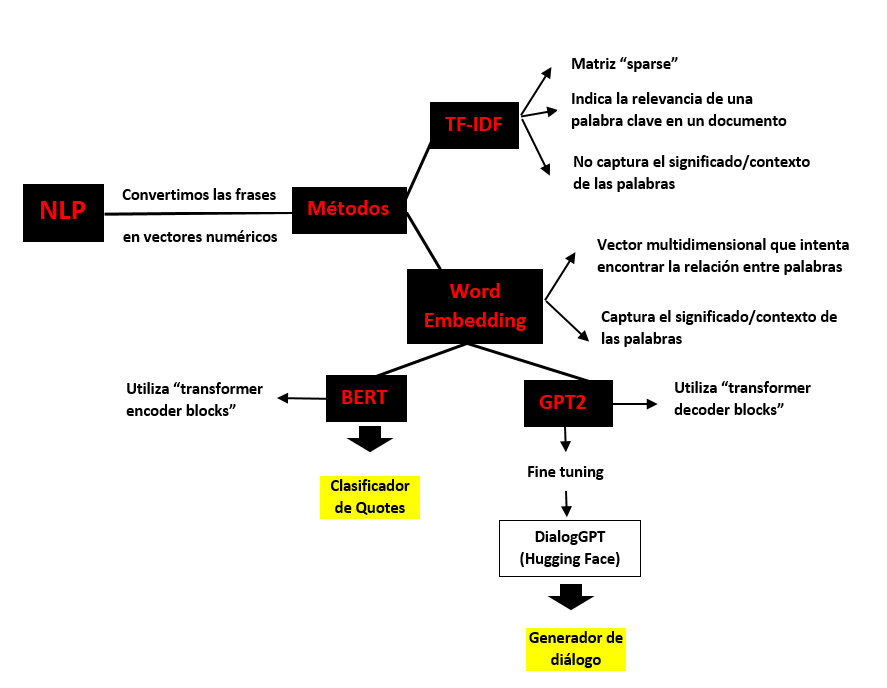

#**Clasificador de "quotes": ¿Quién ha dicho qué?**

![alt text](https://media.giphy.com/media/EU1obAC38GuWI/giphy.gif)

Image from [Giphy](https://giphy.com/)


####Code

In [ ]:
tfidf = TfidfVectorizer(min_df = 0.0005, ngram_range =(1,3))

In [ ]:
X1 = tfidf.fit_transform(friends2[friends2.author.isin(("Ross", "Rachel"))]["quote"])
y1 = friends2[friends2.author.isin(("Ross", "Rachel"))]["author"].values

In [ ]:
X1.shape

(32402, 2041)

In [ ]:
y1.shape

(32402,)

In [ ]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.20, random_state = 0)

In [ ]:
X1_train.shape

(25921, 2041)

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=5, algorithm = "brute")
neigh.fit(X1_train, y1_train)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
y1_pred = neigh.predict(X1_test)

In [ ]:
print(classification_report(y1_test, y1_pred))

              precision    recall  f1-score   support

      Rachel       0.54      0.57      0.55      3227
        Ross       0.55      0.52      0.53      3254

    accuracy                           0.54      6481
   macro avg       0.54      0.54      0.54      6481
weighted avg       0.54      0.54      0.54      6481



#**Confusion Matrix with two Characters: Ross & Rachel**

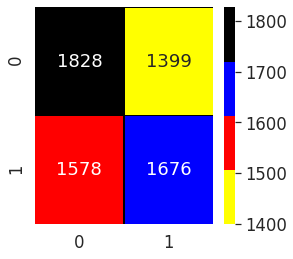

In [ ]:
#@title
cm = confusion_matrix(y1_test, y1_pred)
plt.figure(figsize = (4,4))
palette = ["yellow","red","blue","black"]
_ = sns.heatmap(cm, annot = True, fmt='g', cmap = palette, linecolor = "black", linewidths=0.5)

####Code

In [ ]:
tfidf = TfidfVectorizer(min_df = 0.0005, ngram_range =(1,3))

In [ ]:
X2 = tfidf.fit_transform(friends2["quote"])
y2 = friends2["author"].values

In [ ]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.20, random_state = 0)

In [ ]:
X2_train.shape

(70824, 2029)

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=5, algorithm = "brute")
neigh.fit(X2_train, y2_train)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
y2_pred = neigh.predict(X2_test)

In [ ]:
print(classification_report(y2_test, y2_pred))

              precision    recall  f1-score   support

    Chandler       0.19      0.29      0.23      2751
        Joey       0.21      0.26      0.23      3035
      Monica       0.19      0.18      0.19      2742
      Phoebe       0.21      0.16      0.18      2803
      Rachel       0.24      0.17      0.20      3236
        Ross       0.22      0.18      0.20      3140

    accuracy                           0.21     17707
   macro avg       0.21      0.21      0.20     17707
weighted avg       0.21      0.21      0.20     17707



#**Confusion Matrix with the 6 main characters**

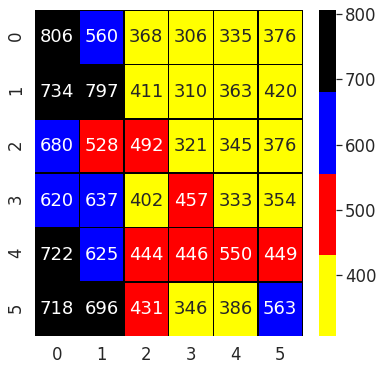

In [ ]:
#@title
cm = confusion_matrix(y2_test, y2_pred)
plt.figure(figsize = (6,6))
palette = ["yellow","red","blue","black"]
_ = sns.heatmap(cm, annot = True, fmt='g', cmap = palette, linecolor = "black", linewidths=0.5)

#### Code

I used the code from this article:

https://towardsdatascience.com/make-your-own-rick-sanchez-bot-with-transformers-and-dialogpt-fine-tuning-f85e6d1f4e30

In [ ]:
!pip install transformers

In [ ]:
import glob
import logging
import os
import pickle
import random
import re
import shutil
from typing import Dict, List, Tuple

import pandas as pd
import numpy as np
import torch

from sklearn.model_selection import train_test_split

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler
from tqdm.notebook import tqdm, trange

from pathlib import Path

from transformers import (
    MODEL_WITH_LM_HEAD_MAPPING,
    WEIGHTS_NAME,
    AdamW,
    AutoConfig,
    AutoModelWithLMHead,
    AutoTokenizer,
    PreTrainedModel,
    PreTrainedTokenizer,
    get_linear_schedule_with_warmup,
)


try:
    from torch.utils.tensorboard import SummaryWriter
except ImportError:
    from tensorboardX import SummaryWriter

# Configs
logger = logging.getLogger(__name__)

MODEL_CONFIG_CLASSES = list(MODEL_WITH_LM_HEAD_MAPPING.keys())
MODEL_TYPES = tuple(conf.model_type for conf in MODEL_CONFIG_CLASSES)


In [ ]:
class Args():
    def __init__(self):
        self.output_dir = '/content/gdrive/MyDrive/Colab Notebooks/output-small'
        self.model_type = 'gpt2'
        self.model_name_or_path = 'microsoft/DialoGPT-medium' 
        self.config_name = 'microsoft/DialoGPT-medium'
        self.tokenizer_name = 'microsoft/DialoGPT-medium'
        self.cache_dir = 'cached'
        self.block_size = 512
        self.do_train = True
        self.do_eval = True
        self.evaluate_during_training = False
        self.per_gpu_train_batch_size = 4
        self.per_gpu_eval_batch_size = 4
        self.gradient_accumulation_steps = 1
        self.learning_rate = 5e-5
        self.weight_decay = 0.0
        self.adam_epsilon = 1e-8
        self.max_grad_norm = 1.0
        self.num_train_epochs = 5
        self.max_steps = -1
        self.warmup_steps = 0
        self.logging_steps = 1000
        self.save_steps = 3500
        self.save_total_limit = None
        self.eval_all_checkpoints = False
        self.no_cuda = False
        self.overwrite_output_dir = True
        self.overwrite_cache = True
        self.should_continue = False
        self.seed = 42
        self.local_rank = -1
        self.fp16 = False
        self.fp16_opt_level = 'O1'

args = Args()

In [ ]:
script_ross = pd.read_excel('/content/gdrive/MyDrive/Colab Notebooks/script_ross.xlsx')

In [ ]:
script_ross.head()

,author,episode_number,episode_title,quote,quote_order,season,To Whom,Conversation
0,Carol,2.0,The Sonogram At The End,Hello!,21.0,1.0,Ross,"Ross, Carol"
1,Ross,2.0,The Sonogram At The End,"You look great. I, uh... I hate that.",22.0,1.0,Carol,"Ross, Carol"
2,Carol,2.0,The Sonogram At The End,Sorry. You look good too.,23.0,1.0,Ross,"Ross, Carol"
3,Ross,2.0,The Sonogram At The End,"Ah, well, in here, anyone who... stands erect....",24.0,1.0,Carol,"Ross, Carol"
4,Carol,2.0,The Sonogram At The End,A lesbian?,25.0,1.0,Ross,"Ross, Carol"


In [ ]:
script_ross["quote"] = script_ross["quote"].str.replace("\(([^)]+)\)","").str.strip()

In [ ]:
contexted = []
n = 7
for i in range(n, len(script_ross['quote'])):
  row = []
  prev = i - 1 - n # we additionally subtract 1, so row will contain current response and 7 previous responses  
  for j in range(i, prev, -1):
    row.append(script_ross['quote'][j])
  contexted.append(row)
columns = ['response', 'context'] 
columns = columns + ['context/'+str(i) for i in range(n-1)]
df = pd.DataFrame.from_records(contexted, columns=columns)
df.head(5)

,response,context,context/0,context/1,context/2,context/3,context/4,context/5
0,"Why- why are you here, Carol?","Marty's still totally paranoid. Oh, and, uh-","Well... you never know. How's, um.. how's the ...",A lesbian?,"Ah, well, in here, anyone who... stands erect....",Sorry. You look good too.,"You look great. I, uh... I hate that.",Hello!
1,I'm pregnant.,"Why- why are you here, Carol?","Marty's still totally paranoid. Oh, and, uh-","Well... you never know. How's, um.. how's the ...",A lesbian?,"Ah, well, in here, anyone who... stands erect....",Sorry. You look good too.,"You look great. I, uh... I hate that."
2,Pregnant?!,I'm pregnant.,"Why- why are you here, Carol?","Marty's still totally paranoid. Oh, and, uh-","Well... you never know. How's, um.. how's the ...",A lesbian?,"Ah, well, in here, anyone who... stands erect....",Sorry. You look good too.
3,I'm just cleaning up.,Pregnant?!,I'm pregnant.,"Why- why are you here, Carol?","Marty's still totally paranoid. Oh, and, uh-","Well... you never know. How's, um.. how's the ...",A lesbian?,"Ah, well, in here, anyone who... stands erect...."
4,D'ya.. uh.. d'ya need any help?,I'm just cleaning up.,Pregnant?!,I'm pregnant.,"Why- why are you here, Carol?","Marty's still totally paranoid. Oh, and, uh-","Well... you never know. How's, um.. how's the ...",A lesbian?


In [ ]:
trn_df, val_df = train_test_split(df, test_size = 0.1)

In [ ]:
def construct_conv(row, tokenizer, eos = True):
    flatten = lambda l: [item for sublist in l for item in sublist]
    conv = list(reversed([tokenizer.encode(x) + [tokenizer.eos_token_id] for x in row]))
    conv = flatten(conv)
    return conv

class ConversationDataset(Dataset):
    def __init__(self, tokenizer: PreTrainedTokenizer, args, df, block_size=512):

        block_size = block_size - (tokenizer.model_max_length - tokenizer.max_len_single_sentence)

        directory = args.cache_dir
        cached_features_file = os.path.join(
            directory, args.model_type + "_cached_lm_" + str(block_size)
        )

        if os.path.exists(cached_features_file) and not args.overwrite_cache:
            logger.info("Loading features from cached file %s", cached_features_file)
            with open(cached_features_file, "rb") as handle:
                self.examples = pickle.load(handle)
        else:
            logger.info("Creating features from dataset file at %s", directory)

            self.examples = []
            for _, row in df.iterrows():
                conv = construct_conv(row, tokenizer)
                self.examples.append(conv)

            logger.info("Saving features into cached file %s", cached_features_file)
            with open(cached_features_file, "wb") as handle:
                pickle.dump(self.examples, handle, protocol=pickle.HIGHEST_PROTOCOL)

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, item):
        return torch.tensor(self.examples[item], dtype=torch.long)
      
# Cacheing and storing of data/checkpoints

def load_and_cache_examples(args, tokenizer, df_trn, df_val, evaluate=False):
    return ConversationDataset(tokenizer, args, df_val if evaluate else df_trn)

def set_seed(args):
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if args.n_gpu > 0:
        torch.cuda.manual_seed_all(args.seed)

def _sorted_checkpoints(args, checkpoint_prefix="checkpoint", use_mtime=False) -> List[str]:
    ordering_and_checkpoint_path = []

    glob_checkpoints = glob.glob(os.path.join(args.output_dir, "{}-*".format(checkpoint_prefix)))

    for path in glob_checkpoints:
        if use_mtime:
            ordering_and_checkpoint_path.append((os.path.getmtime(path), path))
        else:
            regex_match = re.match(".*{}-([0-9]+)".format(checkpoint_prefix), path)
            if regex_match and regex_match.groups():
                ordering_and_checkpoint_path.append((int(regex_match.groups()[0]), path))

    checkpoints_sorted = sorted(ordering_and_checkpoint_path)
    checkpoints_sorted = [checkpoint[1] for checkpoint in checkpoints_sorted]
    return checkpoints_sorted

def _rotate_checkpoints(args, checkpoint_prefix="checkpoint", use_mtime=False) -> None:
    if not args.save_total_limit:
        return
    if args.save_total_limit <= 0:
        return

    # Check if we should delete older checkpoint(s)
    checkpoints_sorted = _sorted_checkpoints(args, checkpoint_prefix, use_mtime)
    if len(checkpoints_sorted) <= args.save_total_limit:
        return

    number_of_checkpoints_to_delete = max(0, len(checkpoints_sorted) - args.save_total_limit)
    checkpoints_to_be_deleted = checkpoints_sorted[:number_of_checkpoints_to_delete]
    for checkpoint in checkpoints_to_be_deleted:
        logger.info("Deleting older checkpoint [{}] due to args.save_total_limit".format(checkpoint))
        shutil.rmtree(checkpoint)

In [ ]:
def train(args, train_dataset, model: PreTrainedModel, tokenizer: PreTrainedTokenizer) -> Tuple[int, float]:
    """ Train the model """
    if args.local_rank in [-1, 0]:
        tb_writer = SummaryWriter()

    args.train_batch_size = args.per_gpu_train_batch_size * max(1, args.n_gpu)

    def collate(examples: List[torch.Tensor]):
        if tokenizer._pad_token is None:
            return pad_sequence(examples, batch_first=True)
        return pad_sequence(examples, batch_first=True, padding_value=tokenizer.pad_token_id)

    train_sampler = RandomSampler(train_dataset) if args.local_rank == -1 else DistributedSampler(train_dataset)
    train_dataloader = DataLoader(
        train_dataset, sampler=train_sampler, batch_size=args.train_batch_size, collate_fn=collate, drop_last = True
    )

    if args.max_steps > 0:
        t_total = args.max_steps
        args.num_train_epochs = args.max_steps // (len(train_dataloader) // args.gradient_accumulation_steps) + 1
    else:
        t_total = len(train_dataloader) // args.gradient_accumulation_steps * args.num_train_epochs

    model = model.module if hasattr(model, "module") else model  # Take care of distributed/parallel training
    model.resize_token_embeddings(len(tokenizer))
    # add_special_tokens_(model, tokenizer)


    # Prepare optimizer and schedule (linear warmup and decay)
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": args.weight_decay,
        },
        {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0},
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=args.learning_rate, eps=args.adam_epsilon)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=args.warmup_steps, num_training_steps=t_total
    )

    # Check if saved optimizer or scheduler states exist
    if (
        args.model_name_or_path
        and os.path.isfile(os.path.join(args.model_name_or_path, "optimizer.pt"))
        and os.path.isfile(os.path.join(args.model_name_or_path, "scheduler.pt"))
    ):
        # Load in optimizer and scheduler states
        optimizer.load_state_dict(torch.load(os.path.join(args.model_name_or_path, "optimizer.pt")))
        scheduler.load_state_dict(torch.load(os.path.join(args.model_name_or_path, "scheduler.pt")))

    if args.fp16:
        try:
            from apex import amp
        except ImportError:
            raise ImportError("Please install apex from https://www.github.com/nvidia/apex to use fp16 training.")
        model, optimizer = amp.initialize(model, optimizer, opt_level=args.fp16_opt_level)

    # multi-gpu training (should be after apex fp16 initialization)
    if args.n_gpu > 1:
        model = torch.nn.DataParallel(model)

    # Distributed training (should be after apex fp16 initialization)
    if args.local_rank != -1:
        model = torch.nn.parallel.DistributedDataParallel(
            model, device_ids=[args.local_rank], output_device=args.local_rank, find_unused_parameters=True
        )

    # Train!
    logger.info("***** Running training *****")
    logger.info("  Num examples = %d", len(train_dataset))
    logger.info("  Num Epochs = %d", args.num_train_epochs)
    logger.info("  Instantaneous batch size per GPU = %d", args.per_gpu_train_batch_size)
    logger.info(
        "  Total train batch size (w. parallel, distributed & accumulation) = %d",
        args.train_batch_size
        * args.gradient_accumulation_steps
        * (torch.distributed.get_world_size() if args.local_rank != -1 else 1),
    )
    logger.info("  Gradient Accumulation steps = %d", args.gradient_accumulation_steps)
    logger.info("  Total optimization steps = %d", t_total)

    global_step = 0
    epochs_trained = 0
    steps_trained_in_current_epoch = 0
    # Check if continuing training from a checkpoint
    if args.model_name_or_path and os.path.exists(args.model_name_or_path):
        try:
            # set global_step to gobal_step of last saved checkpoint from model path
            checkpoint_suffix = args.model_name_or_path.split("-")[-1].split("/")[0]
            global_step = int(checkpoint_suffix)
            epochs_trained = global_step // (len(train_dataloader) // args.gradient_accumulation_steps)
            steps_trained_in_current_epoch = global_step % (len(train_dataloader) // args.gradient_accumulation_steps)

            logger.info("  Continuing training from checkpoint, will skip to saved global_step")
            logger.info("  Continuing training from epoch %d", epochs_trained)
            logger.info("  Continuing training from global step %d", global_step)
            logger.info("  Will skip the first %d steps in the first epoch", steps_trained_in_current_epoch)
        except ValueError:
            logger.info("  Starting fine-tuning.")

    tr_loss, logging_loss = 0.0, 0.0

    model.zero_grad()
    train_iterator = trange(
        epochs_trained, int(args.num_train_epochs), desc="Epoch", disable=args.local_rank not in [-1, 0]
    )
    set_seed(args)  # Added here for reproducibility
    for _ in train_iterator:
        epoch_iterator = tqdm(train_dataloader, desc="Iteration", disable=args.local_rank not in [-1, 0])
        for step, batch in enumerate(epoch_iterator):

            # Skip past any already trained steps if resuming training
            if steps_trained_in_current_epoch > 0:
                steps_trained_in_current_epoch -= 1
                continue

            inputs, labels = (batch, batch)
            if inputs.shape[1] > 1024: continue
            inputs = inputs.to(args.device)
            labels = labels.to(args.device)
            model.train()
            outputs = model(inputs, labels=labels)
            loss = outputs[0]  # model outputs are always tuple in transformers (see doc)

            if args.n_gpu > 1:
                loss = loss.mean()  # mean() to average on multi-gpu parallel training
            if args.gradient_accumulation_steps > 1:
                loss = loss / args.gradient_accumulation_steps

            if args.fp16:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()

            tr_loss += loss.item()
            if (step + 1) % args.gradient_accumulation_steps == 0:
                if args.fp16:
                    torch.nn.utils.clip_grad_norm_(amp.master_params(optimizer), args.max_grad_norm)
                else:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), args.max_grad_norm)
                optimizer.step()
                scheduler.step()  # Update learning rate schedule
                model.zero_grad()
                global_step += 1

                if args.local_rank in [-1, 0] and args.logging_steps > 0 and global_step % args.logging_steps == 0:
                    # Log metrics
                    if (
                        args.local_rank == -1 and args.evaluate_during_training
                    ):  # Only evaluate when single GPU otherwise metrics may not average well
                        results = evaluate(args, model, tokenizer)
                        for key, value in results.items():
                            tb_writer.add_scalar("eval_{}".format(key), value, global_step)
                    tb_writer.add_scalar("lr", scheduler.get_lr()[0], global_step)
                    tb_writer.add_scalar("loss", (tr_loss - logging_loss) / args.logging_steps, global_step)
                    logging_loss = tr_loss

                if args.local_rank in [-1, 0] and args.save_steps > 0 and global_step % args.save_steps == 0:
                    checkpoint_prefix = "checkpoint"
                    # Save model checkpoint
                    output_dir = os.path.join(args.output_dir, "{}-{}".format(checkpoint_prefix, global_step))
                    os.makedirs(output_dir, exist_ok=True)
                    model_to_save = (
                        model.module if hasattr(model, "module") else model
                    )  # Take care of distributed/parallel training
                    model_to_save.save_pretrained(output_dir)
                    tokenizer.save_pretrained(output_dir)

                    torch.save(args, os.path.join(output_dir, "training_args.bin"))
                    logger.info("Saving model checkpoint to %s", output_dir)

                    _rotate_checkpoints(args, checkpoint_prefix)

                    torch.save(optimizer.state_dict(), os.path.join(output_dir, "optimizer.pt"))
                    torch.save(scheduler.state_dict(), os.path.join(output_dir, "scheduler.pt"))
                    logger.info("Saving optimizer and scheduler states to %s", output_dir)

            if args.max_steps > 0 and global_step > args.max_steps:
                epoch_iterator.close()
                break
        if args.max_steps > 0 and global_step > args.max_steps:
            train_iterator.close()
            break

    if args.local_rank in [-1, 0]:
        tb_writer.close()

    return global_step, tr_loss / global_step

# Evaluation of some model

def evaluate(args, model: PreTrainedModel, tokenizer: PreTrainedTokenizer, df_trn, df_val, prefix="") -> Dict:
    # Loop to handle MNLI double evaluation (matched, mis-matched)
    eval_output_dir = args.output_dir

    eval_dataset = load_and_cache_examples(args, tokenizer, df_trn, df_val, evaluate=True)
    os.makedirs(eval_output_dir, exist_ok=True)
    args.eval_batch_size = args.per_gpu_eval_batch_size * max(1, args.n_gpu)
    # Note that DistributedSampler samples randomly

    def collate(examples: List[torch.Tensor]):
        if tokenizer._pad_token is None:
            return pad_sequence(examples, batch_first=True)
        return pad_sequence(examples, batch_first=True, padding_value=tokenizer.pad_token_id)

    eval_sampler = SequentialSampler(eval_dataset)
    eval_dataloader = DataLoader(
        eval_dataset, sampler=eval_sampler, batch_size=args.eval_batch_size, collate_fn=collate, drop_last = True
    )

    # multi-gpu evaluate
    if args.n_gpu > 1:
        model = torch.nn.DataParallel(model)

    # Eval!
    logger.info("***** Running evaluation {} *****".format(prefix))
    logger.info("  Num examples = %d", len(eval_dataset))
    logger.info("  Batch size = %d", args.eval_batch_size)
    eval_loss = 0.0
    nb_eval_steps = 0
    model.eval()

    for batch in tqdm(eval_dataloader, desc="Evaluating"):
        inputs, labels = (batch, batch)
        inputs = inputs.to(args.device)
        labels = labels.to(args.device)

        with torch.no_grad():
            outputs = model(inputs, labels=labels)
            lm_loss = outputs[0]
            eval_loss += lm_loss.mean().item()
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    perplexity = torch.exp(torch.tensor(eval_loss))

    result = {"perplexity": perplexity}

    output_eval_file = os.path.join(eval_output_dir, prefix, "eval_results.txt")
    with open(output_eval_file, "w") as writer:
        logger.info("***** Eval results {} *****".format(prefix))
        for key in sorted(result.keys()):
            logger.info("  %s = %s", key, str(result[key]))
            writer.write("%s = %s\n" % (key, str(result[key])))

    return result

In [ ]:
def main(df_trn, df_val):
      args = Args()

      if args.should_continue:
          sorted_checkpoints = _sorted_checkpoints(args)
          if len(sorted_checkpoints) == 0:
              raise ValueError("Used --should_continue but no checkpoint was found in --output_dir.")
          else:
              args.model_name_or_path = sorted_checkpoints[-1]

      if (
          os.path.exists(args.output_dir)
          and os.listdir(args.output_dir)
          and args.do_train
          and not args.overwrite_output_dir
          and not args.should_continue
      ):
          raise ValueError(
              "Output directory ({}) already exists and is not empty. Use --overwrite_output_dir to overcome.".format(
                  args.output_dir
              )
          )

      # Setup CUDA, GPU & distributed training
      device = torch.device("cuda")
      args.n_gpu = torch.cuda.device_count()
      args.device = device

      # Setup logging
      logging.basicConfig(
          format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
          datefmt="%m/%d/%Y %H:%M:%S",
          level=logging.INFO if args.local_rank in [-1, 0] else logging.WARN,
      )
      logger.warning(
          "Process rank: %s, device: %s, n_gpu: %s, distributed training: %s, 16-bits training: %s",
          args.local_rank,
          device,
          args.n_gpu,
          bool(args.local_rank != -1),
          args.fp16,
      )

      # Set seed
      set_seed(args)

      config = AutoConfig.from_pretrained(args.config_name, cache_dir=args.cache_dir)
      tokenizer = AutoTokenizer.from_pretrained(args.tokenizer_name, cache_dir=args.cache_dir)
      model = AutoModelWithLMHead.from_pretrained(
          args.model_name_or_path,
          from_tf=False,
          config=config,
          cache_dir=args.cache_dir,
      )
      model.to(args.device)

      logger.info("Training/evaluation parameters %s", args)

      # Training
      if args.do_train:
          train_dataset = load_and_cache_examples(args, tokenizer, df_trn, df_val, evaluate=False)

          global_step, tr_loss = train(args, train_dataset, model, tokenizer)
          logger.info(" global_step = %s, average loss = %s", global_step, tr_loss)

      # Saving best-practices: if you use save_pretrained for the model and tokenizer, you can reload them using from_pretrained()
      if args.do_train:
          # Create output directory if needed
          os.makedirs(args.output_dir, exist_ok=True)

          logger.info("Saving model checkpoint to %s", args.output_dir)
          # Save a trained model, configuration and tokenizer using `save_pretrained()`.
          # They can then be reloaded using `from_pretrained()`
          model_to_save = (
              model.module if hasattr(model, "module") else model
          )  # Take care of distributed/parallel training
          model_to_save.save_pretrained(args.output_dir)
          tokenizer.save_pretrained(args.output_dir)

          # Good practice: save your training arguments together with the trained model
          torch.save(args, os.path.join(args.output_dir, "training_args.bin"))

          # Load a trained model and vocabulary that you have fine-tuned
          model = AutoModelWithLMHead.from_pretrained(args.output_dir)
          tokenizer = AutoTokenizer.from_pretrained(args.output_dir)
          model.to(args.device)

      # Evaluation
      results = {}
      if args.do_eval and args.local_rank in [-1, 0]:
          checkpoints = [args.output_dir]
          if args.eval_all_checkpoints:
              checkpoints = list(
                  os.path.dirname(c) for c in sorted(glob.glob(args.output_dir + "/**/" + WEIGHTS_NAME, recursive=True))
              )
              logging.getLogger("transformers.modeling_utils").setLevel(logging.WARN)  # Reduce logging
          logger.info("Evaluate the following checkpoints: %s", checkpoints)
          for checkpoint in checkpoints:
              global_step = checkpoint.split("-")[-1] if len(checkpoints) > 1 else ""
              prefix = checkpoint.split("/")[-1] if checkpoint.find("checkpoint") != -1 else ""

              model = AutoModelWithLMHead.from_pretrained(checkpoint)
              model.to(args.device)
              result = evaluate(args, model, tokenizer, df_trn, df_val, prefix=prefix)
              result = dict((k + "_{}".format(global_step), v) for k, v in result.items())
              results.update(result)

      return results

In [ ]:
#main(trn_df, val_df)

In [ ]:
#@title
tokenizer = AutoTokenizer.from_pretrained('microsoft/DialoGPT-medium')
model = AutoModelWithLMHead.from_pretrained('/content/gdrive/MyDrive/Colab Notebooks/output-small')


#**Generador de diálogo: ¿Qué diría Ross?**


![alt text](https://media.giphy.com/media/FY56lXEc3KY9y/giphy.gif)

Image from [Giphy](https://giphy.com/)


In [ ]:
#@title
# Let's chat for 5 lines
for step in range(5):
    # encode the new user input, add the eos_token and return a tensor in Pytorch
    new_user_input_ids = tokenizer.encode(input(">> User:") + tokenizer.eos_token, return_tensors='pt')
    # print(new_user_input_ids)
# append the new user input tokens to the chat history
    bot_input_ids = torch.cat([chat_history_ids, new_user_input_ids], dim=-1) if step > 0 else new_user_input_ids
# generated a response while limiting the total chat history to 1000 tokens, 
    chat_history_ids = model.generate(
        bot_input_ids, max_length=200,
        pad_token_id=tokenizer.eos_token_id,  
        no_repeat_ngram_size=3,       
        do_sample=True, 
        top_k=100, 
        top_p=0.7,
        temperature = 0.8
    )
    
    # pretty print last ouput tokens from bot
    print("RossBot: {}".format(tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True)))


>> User:Hey Ross, what's up?
RossBot: Nothing much
>> User:Would you like to go for a coffee?
RossBot: Sure
>> User:Should we go to the coffee house?
RossBot: Yeah
>> User:Great, let me take my jacket
RossBot: Alright look I brought the cannoli
>> User:what's a cannoli?
RossBot: It's a big ol'lasagna


**CONVERSATION 1**

* **User**:Hey Ross, how are you?
* **RossBot** good you?
* **User**:All good thanks! So should we have coffee?
* **RossBot** sure
* **User**:where should we go?
* **RossBot** to the bar
* **User**:maybe better a coffee shop
* **RossBot** there you go!
* **User**:great, let's go!
* **RossBot** !!!?!!

**CONVERSATION 2**

* **User**:hey, what's up
* **RossBot** nothing much
* **User**:ok, same here
* **RossBot** so what're you uh what're um you nervous about?
* **User**:I have a job interview
* **RossBot** oh god  oh god  what's wrong with me?
* **User**:nothing!!
* **RossBot** look carol never threw me out of a room before you came along
* **User**:well, things have changed
* **RossBot** !!!?!!

**CONVERSATION 3**

* **User**:Hey, long time no see
* **RossBot**: you didn't tell us about the cat
* **User**:what cat?
* **RossBot**: the one you left in the box
* **User**:it's not mine
* **RossBot**: look it's just a warm fuzzy blanket
* **User**:which color?
* **RossBot**: maroon is nice
* **User**:It's awful
* **RossBot**: it is it is

**CONVERSATION 4**

* **User**:You like this woman, right?
* **RossBot**: yeah
* **User**:you wanna see her again right?
* **RossBot**: sure
* **User**:so what will you do?
* **RossBot**: i'm gonna go out there and see what i can do
* **User**:All right, relax
* **RossBot**: alright
* **User**:you can do it!!
* **RossBot**: !!!?!!

**CONVERSATION 5**

* **User**:what's up?
* **RossBot**: Nothing much uh
* **User**::Are you hungry?
* **RossBot**: Mmmm
* **User**::What would you like to eat?
* **RossBot**: Well um I don't know maybe a nice cold steak but that's it
* **User**::Well, this I can cook
* **RossBot**: That's great
* **User**::Will you buy dessert?
* **RossBot**: !!!?!!,!!'!!